# ****============ CUSTOMER SEGMENTATION =============****

En este cuaderno, exportaré datos e intentaré segmentar a los clientes en un mercado de Brasil utilizando el método de análisis RFM. El objetivo de este proyecto es ayudar al equipo de marketing a determinar su mercado objetivo para ser más específico. Dividiré este cuaderno en las siguientes etapas:

    Contexto
    Preprocesamiento de datos
    Modelado
    Conclusión

Este cuaderno no es demasiado profundo para discutir la teoría, pero daré razones por las cuales hice estos pasos. ¡Empecemos!
1. CONTEXTO

Este conjunto de datos es Olist, el mercado más grande de Brasil. Esta información se recopiló en el período 2016-2018. Olist conecta a pequeñas empresas de todo Brasil para ingresar a sus redes de manera muy sencilla simplemente mediante un contrato. Estos empresarios pueden vender sus productos a través de la plataforma Olist y enviarlos directamente a sus clientes con correos que han trabajado igual que Olist.

Después de que el cliente compre su producto a Olist, el vendedor recibirá una notificación para cumplir de inmediato con el pedido del cliente. Cuando un cliente recibe un producto, el cliente puede dar una calificación de satisfacción y comentarios relacionados con los servicios prestados por el vendedor a través del correo electrónico enviado.

Los datos recopilados están en 9 archivos diferentes, por lo que deben combinarse para obtener todos los datos en función de los parámetros que deseamos. A continuación se muestra un esquema de conexión entre los datos que se utilizarán como punto de referencia al fusionar datos.

![](https://i.imgur.com/HRhd2Y0.png)

In [1]:
#Importing Libraries
#Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#Fetaure Selection
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#Modelling Algoritm
from sklearn.cluster import KMeans

#Model Evaluation
from yellowbrick.cluster import SilhouetteVisualizer

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#Load All The Data
olist_orders = pd.read_csv('./olist_orders_dataset.csv')
olist_products = pd.read_csv('./olist_products_dataset.csv')
olist_items = pd.read_csv('./olist_order_items_dataset.csv')
olist_customers = pd.read_csv('./olist_customers_dataset.csv')
olist_payments = pd.read_csv('./olist_order_payments_dataset.csv')
olist_sellers = pd.read_csv('./olist_sellers_dataset.csv')
olist_geolocation = pd.read_csv('./olist_geolocation_dataset.csv')
olist_reviews = pd.read_csv('./olist_order_reviews_dataset.csv')
olist_product_category_name = pd.read_csv('./product_category_name_translation.csv') #Untuk menerjemahkan dari bahasa Brazil ke Bahasa Inggris

In [3]:
#Menggabungkan semua data-data 
all_data = olist_orders.merge(olist_items, on='order_id', how='left')
all_data = all_data.merge(olist_payments, on='order_id', how='inner')
all_data = all_data.merge(olist_reviews, on='order_id', how='inner')
all_data = all_data.merge(olist_products, on='product_id', how='inner')
all_data = all_data.merge(olist_customers, on='customer_id', how='inner')
all_data = all_data.merge(olist_sellers, on='seller_id', how='inner')
all_data = all_data.merge(olist_product_category_name,on='product_category_name',how='inner')
#all_data = all_data.merge(olist_geolocation, on='seller_zip_code_prefix', how='inner')

In [4]:
#Vea qué porcentaje de datos está en blanco en cada columna
round((all_data.isnull().sum()/ len(all_data)*100),2)

order_id                          0.00
customer_id                       0.00
order_status                      0.00
order_purchase_timestamp          0.00
order_approved_at                 0.01
order_delivered_carrier_date      1.04
order_delivered_customer_date     2.16
order_estimated_delivery_date     0.00
order_item_id                     0.00
product_id                        0.00
seller_id                         0.00
shipping_limit_date               0.00
price                             0.00
freight_value                     0.00
payment_sequential                0.00
payment_type                      0.00
payment_installments              0.00
payment_value                     0.00
review_id                         0.00
review_score                      0.00
review_comment_title             87.99
review_comment_message           57.22
review_creation_date              0.00
review_answer_timestamp           0.00
product_category_name             0.00
product_name_lenght      

In [5]:
# Viendo la información en los datos tanto el número de columnas, como la entrada a la memoria
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116581 entries, 0 to 116580
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       116581 non-null  object 
 1   customer_id                    116581 non-null  object 
 2   order_status                   116581 non-null  object 
 3   order_purchase_timestamp       116581 non-null  object 
 4   order_approved_at              116567 non-null  object 
 5   order_delivered_carrier_date   115368 non-null  object 
 6   order_delivered_customer_date  114066 non-null  object 
 7   order_estimated_delivery_date  116581 non-null  object 
 8   order_item_id                  116581 non-null  float64
 9   product_id                     116581 non-null  object 
 10  seller_id                      116581 non-null  object 
 11  shipping_limit_date            116581 non-null  object 
 12  price                         

# ** 2. PREPROCESAMIENTO DE DATOS **

En esta etapa, dejaremos los datos fuera del ruido / ruido (entradas en blanco, valores atípicos, etc.) para que los datos que se ingresen en el modelo estén limpios y listos para el modelado.

## ** 2.1 Manejo variable **

Esta etapa tiene como objetivo ajustar los tipos de datos en función de su entrada y también eliminar la duplicación de los datos que tenemos



In [6]:
# Cambie el tipo de datos en la columna de fecha para que el tipo de datos finalice
date_columns = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
             'order_estimated_delivery_date', 'shipping_limit_date', 'review_creation_date', 'review_answer_timestamp'] 
for col in date_columns:
    all_data[col] = pd.to_datetime(all_data[col], format='%Y-%m-%d %H:%M:%S')

In [7]:
# Ver si hay datos duplicados
print('Duplicados: ',all_data.duplicated().sum())

Duplicados:  0


In [8]:
#Cree una columna de mes_orden para la exploración de datos
all_data['Month_order'] = all_data['order_purchase_timestamp'].dt.to_period('M').astype('str')

In [9]:
# Elija entradas que van desde 01-2017 hasta 08-2018
#Porque hay datos que están fuera de balance con el promedio de cada mes en los datos antes del 01-2017 y después del 08-2018
# basado en datos de compra / order_purchase_timestamp
start_date = "2017-01-01"
end_date = "2018-08-31"

after_start_date = all_data['order_purchase_timestamp'] >= start_date
before_end_date = all_data['order_purchase_timestamp'] <= end_date
between_two_dates = after_start_date & before_end_date
all_data = all_data.loc[between_two_dates]

In [10]:
# Compartir datos según el tipo de datos
only_numeric = all_data.select_dtypes(include=['int', 'float'])
only_object = all_data.select_dtypes(include=['object'])
only_time = all_data.select_dtypes(include=['datetime', 'timedelta'])

## 2.2 Manejo de valores perdidos

En esta etapa, se hace para eliminar entradas vacías mediante el uso de otras características o el uso de estadísticas (media / mediana)

In [11]:
# Vea qué porcentaje de datos está en blanco en cada columna
round((all_data.isnull().sum()/ len(all_data)*100),2)

order_id                          0.00
customer_id                       0.00
order_status                      0.00
order_purchase_timestamp          0.00
order_approved_at                 0.01
order_delivered_carrier_date      1.01
order_delivered_customer_date     2.12
order_estimated_delivery_date     0.00
order_item_id                     0.00
product_id                        0.00
seller_id                         0.00
shipping_limit_date               0.00
price                             0.00
freight_value                     0.00
payment_sequential                0.00
payment_type                      0.00
payment_installments              0.00
payment_value                     0.00
review_id                         0.00
review_score                      0.00
review_comment_title             87.95
review_comment_message           57.33
review_creation_date              0.00
review_answer_timestamp           0.00
product_category_name             0.00
product_name_lenght      

In [12]:
# Gestiona entradas vacías en la columna order_approved_at
missing_1 = all_data['order_approved_at'] - all_data['order_purchase_timestamp']
print(missing_1.describe())
print('='*50)
print('Mediana desde el momento en que se aprobó la orden: ',missing_1.median())

# tomamos la mediana porque hay quienes aprueban directamente desde el momento en que ordena, algunos son de hasta 60 días
add_1 = all_data[all_data['order_approved_at'].isnull()]['order_purchase_timestamp'] + missing_1.median()
all_data['order_approved_at']= all_data['order_approved_at'].replace(np.nan, add_1)

count                    116178
mean     0 days 10:27:08.897923
std      0 days 21:53:11.220121
min             0 days 00:00:00
25%             0 days 00:12:56
50%             0 days 00:20:46
75%      0 days 14:54:27.750000
max            60 days 10:51:59
dtype: object
Mediana desde el momento en que se aprobó la orden:  0 days 00:20:46


In [13]:
# Gestiona entradas vacías en la columna order_approved_at
all_data[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']].head()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date
0,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13
1,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13
2,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13
3,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43
4,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01


In [14]:
# Gestión de entradas vacías en la columna order_delivered_carrier_date
missing_2 = all_data['order_delivered_carrier_date'] - all_data['order_approved_at']
print(missing_2.describe())
print('='*50)
print('Mediana desde el momento de la solicitud hasta el envío: ',missing_2.median())

# Tomamos la mediana porque algunos barcos están dentro de las 21 horas del tiempo acordado, algunos hasta 107 días
add_2 = all_data[all_data['order_delivered_carrier_date'].isnull()]['order_approved_at'] + missing_2.median()
all_data['order_delivered_carrier_date']= all_data['order_delivered_carrier_date'].replace(np.nan, add_2)

count                    115016
mean     2 days 19:36:08.343613
std      3 days 11:05:42.705027
min         -172 days +18:44:38
25%             0 days 21:12:37
50%      1 days 20:05:56.500000
75%      3 days 14:45:47.750000
max           107 days 01:16:38
dtype: object
Mediana desde el momento de la solicitud hasta el envío:  1 days 20:05:56.500000


In [15]:
# Gestión de entradas vacías en la columna order_delivered_customer_date
missing_3 = all_data['order_delivered_customer_date'] - all_data['order_delivered_carrier_date']
print(missing_3.describe())
print('='*50)
print('Mediana desde el momento en que se envió hasta que el cliente la recibió: ',missing_3.median())

# tomamos la mediana porque hay un tiempo de entrega de -17 días, lo que significa que es atípico, también hay un tiempo de entrega de hasta 205 días
add_3 = all_data[all_data['order_delivered_customer_date'].isnull()]['order_delivered_carrier_date'] + missing_3.median()
all_data['order_delivered_customer_date']= all_data['order_delivered_customer_date'].replace(np.nan, add_3)

count                     113726
mean      9 days 05:09:53.148923
std       8 days 15:22:27.173498
min           -17 days +21:41:31
25%              4 days 01:44:35
50%              7 days 01:35:06
75%      11 days 22:31:48.500000
max            205 days 04:35:00
dtype: object
Mediana desde el momento en que se envió hasta que el cliente la recibió:  7 days 01:35:06


In [16]:
# Manejar las columnas review_comment_title y review_comment_message
#Porque el número de entradas en blanco es muy grande e imposible de completar porque no hay variables que puedan
# usado para calcularlo. Porque este es el comentario y el título del comentario
# Luego eliminaremos la columna

all_data = all_data.drop(['review_comment_title', 'review_comment_message'], axis=1)

In [17]:
# Entrega de entrada vacía en las columnas product_weight_g, product_length_cm, product_height_cm, product_width_cm
#Porque solo hay 1, entonces lo dejamos caer
all_data = all_data.dropna()

In [18]:
# Compruebe si hay entradas en blanco
round((all_data.isnull().sum()/len(all_data)*100),2)

order_id                         0.0
customer_id                      0.0
order_status                     0.0
order_purchase_timestamp         0.0
order_approved_at                0.0
order_delivered_carrier_date     0.0
order_delivered_customer_date    0.0
order_estimated_delivery_date    0.0
order_item_id                    0.0
product_id                       0.0
seller_id                        0.0
shipping_limit_date              0.0
price                            0.0
freight_value                    0.0
payment_sequential               0.0
payment_type                     0.0
payment_installments             0.0
payment_value                    0.0
review_id                        0.0
review_score                     0.0
review_creation_date             0.0
review_answer_timestamp          0.0
product_category_name            0.0
product_name_lenght              0.0
product_description_lenght       0.0
product_photos_qty               0.0
product_weight_g                 0.0
p

In [19]:
# Ajuste el tipo de datos con los datos de entrada
all_data = all_data.astype({'order_item_id': 'int64', 
                            'product_name_lenght': 'int64',
                            'product_description_lenght':'int64', 
                            'product_photos_qty':'int64'})

## ** 2.3. Extracción de características **

En esta etapa, la adición de nuevas columnas que contienen cálculos de varias columnas para obtener una nueva característica



In [20]:
#Cree una columna order_process_time para ver cuánto tiempo llevará iniciar el pedido hasta que los
# artículos son aceptados por los clientes
all_data['order_process_time'] = all_data['order_delivered_customer_date'] - all_data['order_purchase_timestamp']

In [21]:
#Cree una columna order_delivery_time para ver cuánto tiempo requiere el tiempo de envío para cada pedido (desde que se envia
#hasta que llega a manos del cliente)
all_data['order_delivery_time'] = all_data['order_delivered_customer_date'] - all_data['order_delivered_carrier_date']

In [22]:
#Cree una columna order_time_accuracy para ver si desde el tiempo estimado hasta el tiempo en que llego, fue
#algo apropiado o llego tarde
# Si el valor es + positivo, entonces es más rápido, si es 0, está justo a tiempo, pero si es negativo, llego tarde
all_data['order_accuracy_time'] = all_data['order_estimated_delivery_date'] - all_data['order_delivered_customer_date'] 

In [23]:
#Cree una columna order_approved_time para ver cuánto tiempo tomará desde el pedido hasta la aprobación
all_data['order_approved_time'] = all_data['order_approved_at'] - all_data['order_purchase_timestamp'] 

In [24]:
#Cree una columna review_send_time para averiguar cuánto tiempo tardo en enviarse la encuesta de satisfacción después de
#recibir el artículo.
all_data['review_send_time'] = all_data['review_creation_date'] - all_data['order_delivered_customer_date']

In [25]:
#Cree una columna review_answer_time para averiguar cuánto tiempo llevará completar una revisión de respuesta después de
# enviar una encuesta de satisfacción del cliente.
all_data['review_answer_time'] = all_data['review_answer_timestamp'] - all_data['review_creation_date']

In [26]:
# Combine las columnas product_length_cm, product_height_cm y product_width_cm para convertirlo en un volumen
# con una nueva columna, volumen_producto
all_data['product_volume'] = all_data['product_length_cm'] * all_data['product_height_cm'] * all_data['product_width_cm']

## ** 2.4 Exploración de datos **

Esta etapa se lleva a cabo la exploración de datos para obtener información o información que puede ser útil para la empresa.

Text(0, 0.5, 'Product category')

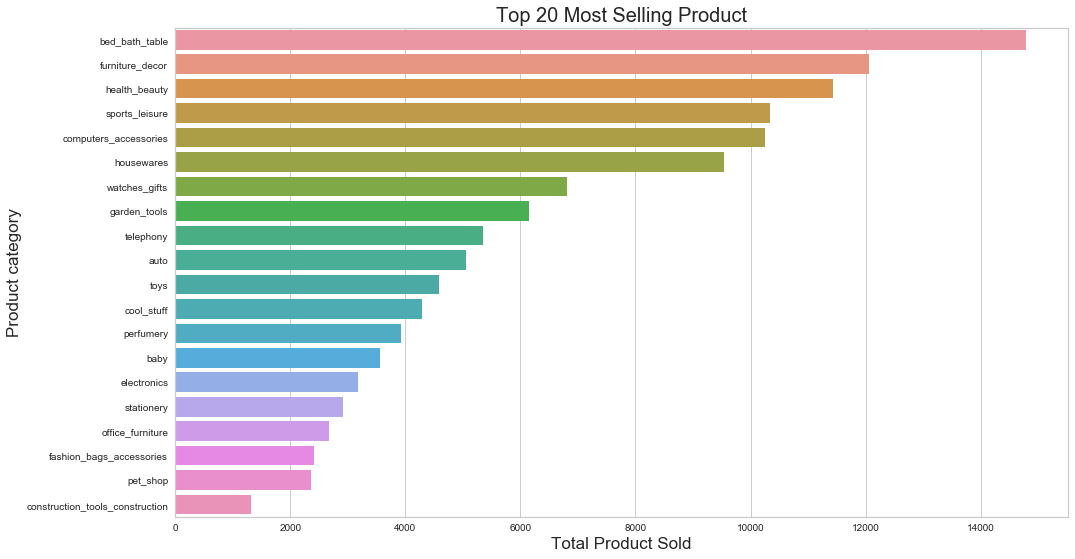

In [27]:
# ¿Qué productos tienen más demanda?
top_20_product_best_seller = all_data['order_item_id'].groupby(all_data['product_category_name_english']).sum().sort_values(ascending=False)[:20]
#print(top_20_product_best_seller)

# Lo trazamos para visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_product_best_seller.index,x=top_20_product_best_seller.values)
plt.title('Top 20 Most Selling Product',fontsize=20)
plt.xlabel('Total Product Sold',fontsize=17)
plt.ylabel('Product category',fontsize=17)

Text(0, 0.5, 'City')

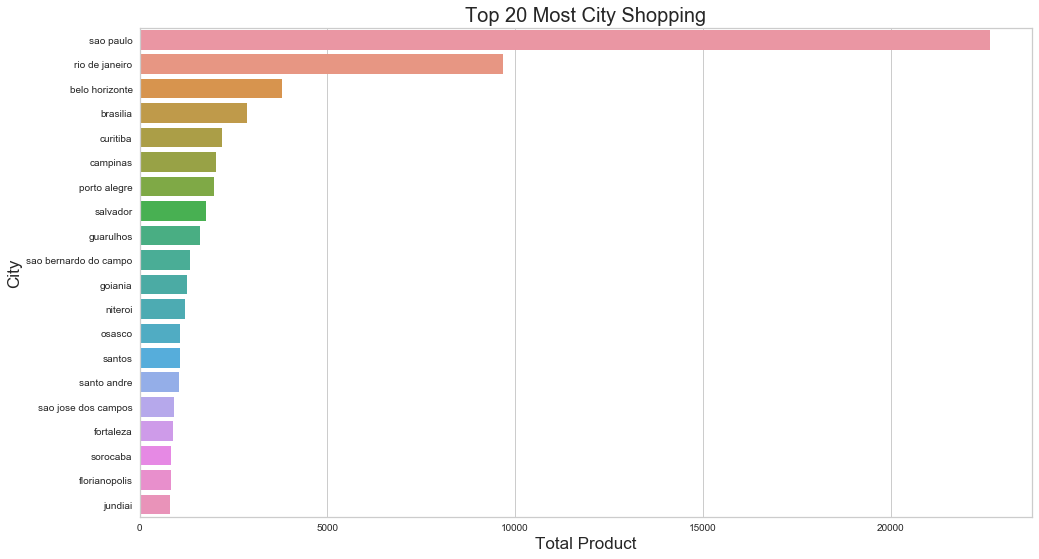

In [28]:
top_20_city_shopping = all_data['order_item_id'].groupby(all_data['customer_city']).sum().sort_values(ascending=False)[:20]
#print(top_20_city_shopping)

# ¿Qué ciudad compra más?
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_city_shopping.index,x=top_20_city_shopping.values)
plt.title('Top 20 Most City Shopping',fontsize=20)
plt.xlabel('Total Product',fontsize=17)
plt.ylabel('City',fontsize=17)

Text(0, 0.5, 'Customer ID')

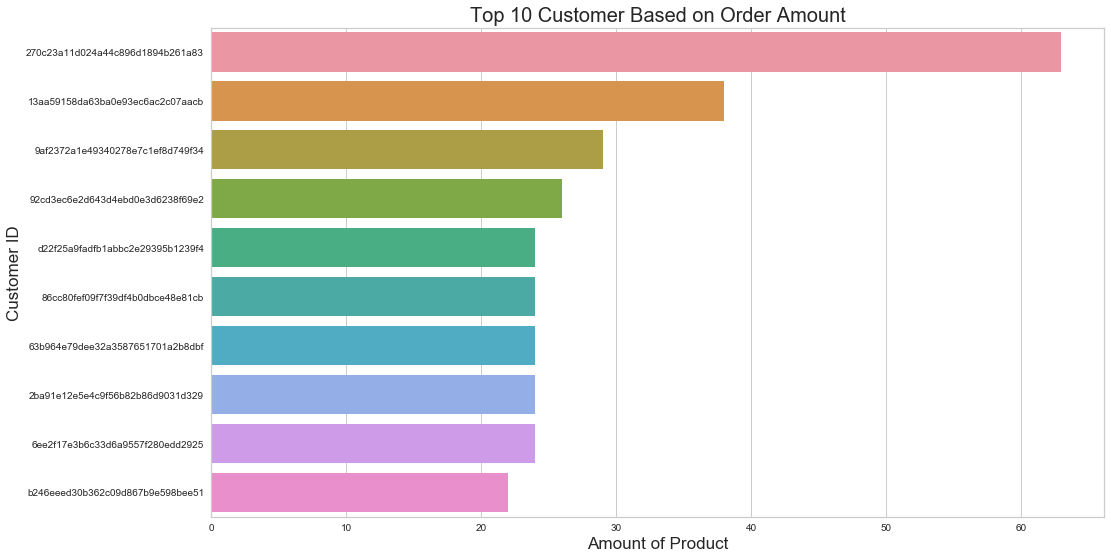

In [29]:
# ¿Quién tiene el mayor número de compras en función de la cantidad de pedidos?
top_10_customer_shopping = all_data['order_item_id'].groupby(all_data['customer_id']).count().sort_values(ascending=False)[:10]
#print(top_10_customer_shopping)

# Lo trazamos para visualización
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_customer_shopping.index,x=top_10_customer_shopping.values)
plt.title('Top 10 Customer Based on Order Amount',fontsize=20)
plt.xlabel('Amount of Product',fontsize=17)
plt.ylabel('Customer ID',fontsize=17)

Text(0, 0.5, 'Customer ID')

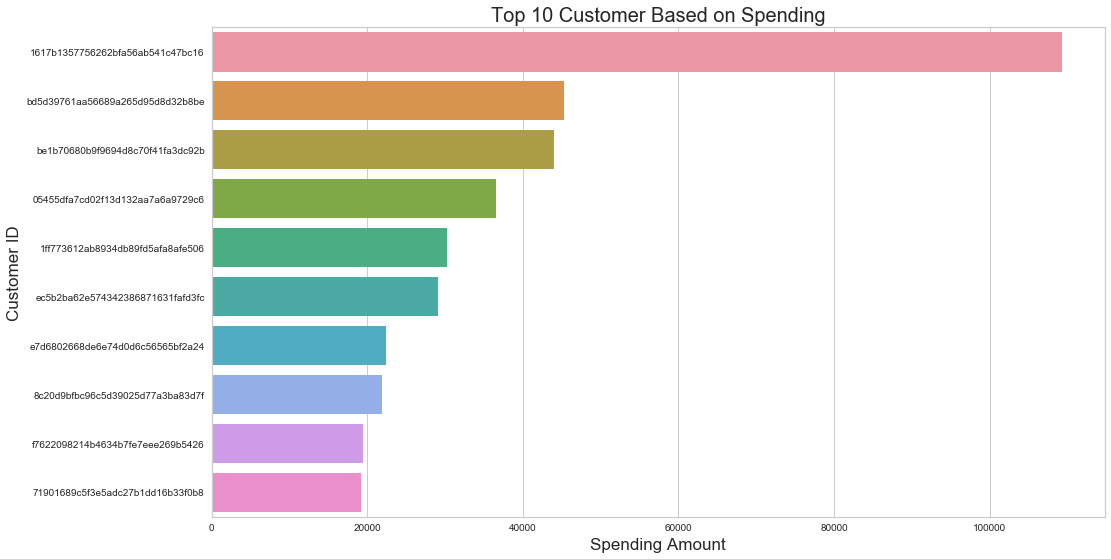

In [30]:
# ¿Quién es el cliente con más gasto en compras por precio?
top_10_customer_shopping = all_data['payment_value'].groupby(all_data['customer_id']).sum().sort_values(ascending=False)[:10]
#print(top_10_customer_shopping)

fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_customer_shopping.index,x=top_10_customer_shopping.values)
plt.title('Top 10 Customer Based on Spending',fontsize=20)
plt.xlabel('Spending Amount',fontsize=17)
plt.ylabel('Customer ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

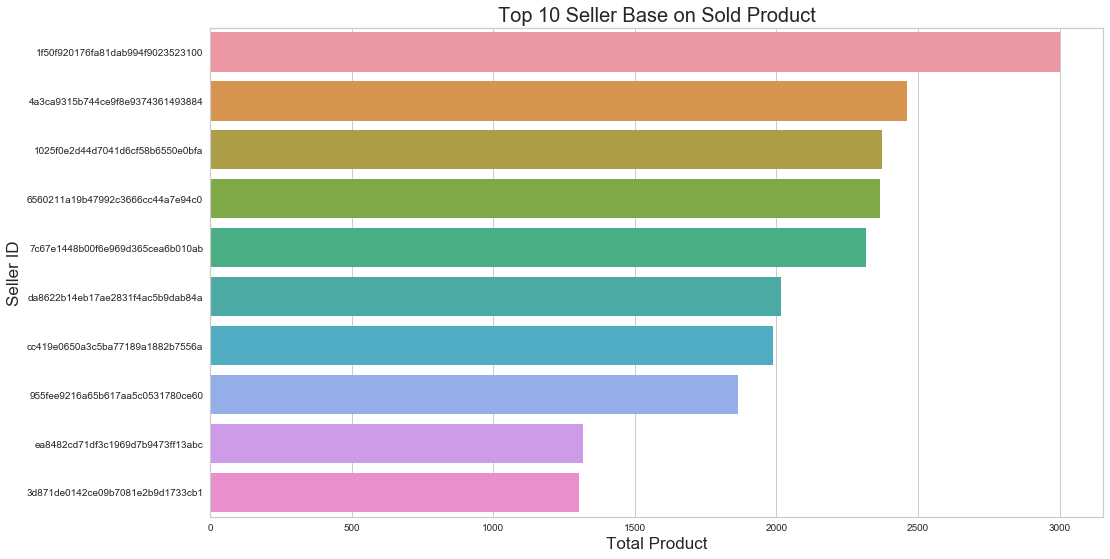

In [31]:
# ¿Qué vendedores venden más? En terminos de cantidad de productos vendidos
top_10_seller_order = all_data['order_item_id'].groupby(all_data['seller_id']).sum().sort_values(ascending=False)[:10]
#print(top_10_seller_order)

fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.values)
plt.title('Top 10 Seller Base on Sold Product',fontsize=20)
plt.xlabel('Total Product',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

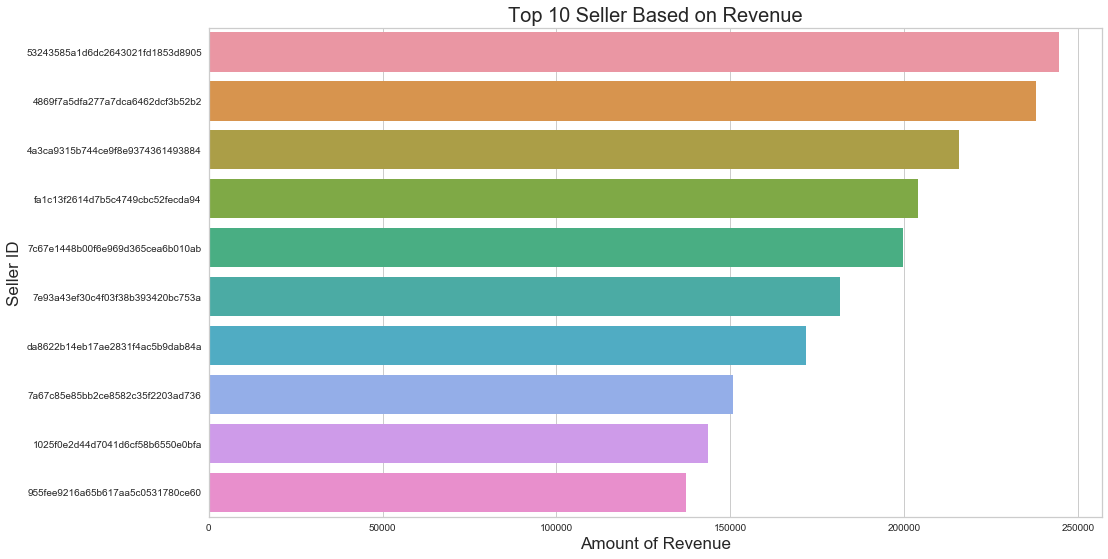

In [32]:
# Vendedor, ¿cuál es el mayor vendedor basado en ingresos?
top_10_seller_order = all_data['price'].groupby(all_data['seller_id']).sum().sort_values(ascending=False)[:10]
#print(top_10_seller_order)

fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.values)
plt.title('Top 10 Seller Based on Revenue',fontsize=20)
plt.xlabel('Amount of Revenue',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

Text(0, 0.5, 'Seller ID')

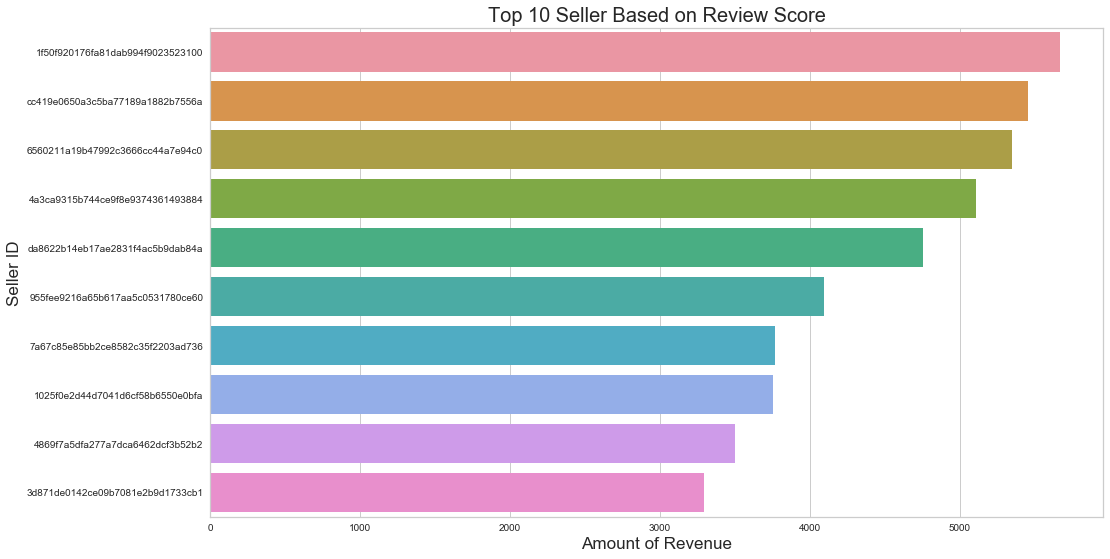

In [33]:
# Vendedor, ¿cuál es el mayor vendedor basado en la review de los clientes?
top_10_seller_order = all_data[all_data['review_score'] == 5].groupby(all_data['seller_id']).sum().sort_values(by=['review_score'],ascending=False)[:10]
#print(top_10_seller_order)

fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_seller_order.index,x=top_10_seller_order.review_score)
plt.title('Top 10 Seller Based on Review Score',fontsize=20)
plt.xlabel('Amount of Revenue',fontsize=17)
plt.ylabel('Seller ID',fontsize=17)

In [34]:
# Distribución del estado del pedido del cliente
round(all_data.order_status.value_counts() / len(all_data),2)
#98% de los productos entregados, 1% enviado

delivered     0.98
shipped       0.01
canceled      0.00
processing    0.00
invoiced      0.00
approved      0.00
Name: order_status, dtype: float64

Text(0, 0.5, 'Time (Day)')

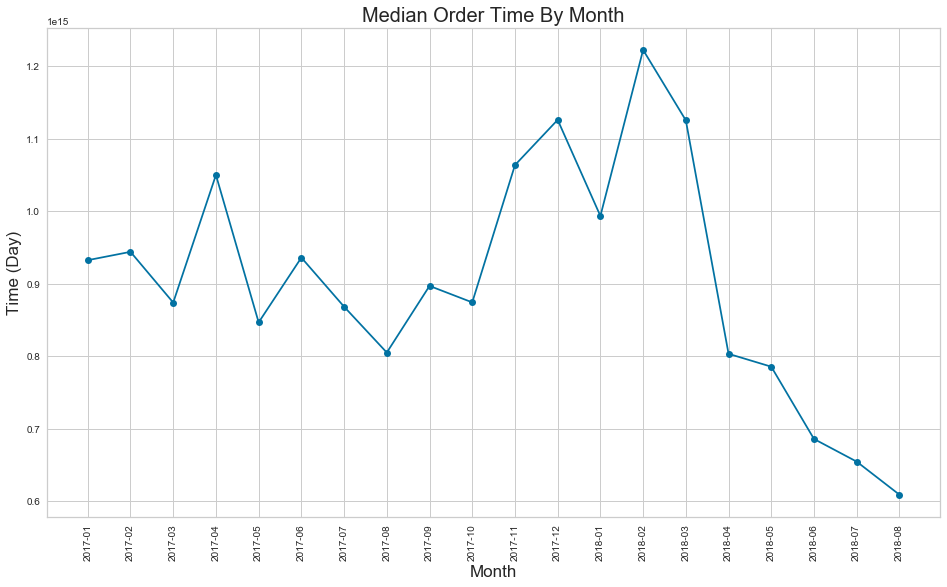

In [35]:
# ¿Cuál es el tiempo promedio desde el pedido hasta el recibo que se necesita en cada pedido mensual?
order_time_by_month = all_data['order_process_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

fig=plt.figure(figsize=(16,9))
plt.plot(order_time_by_month.index, order_time_by_month.values, marker='o')
plt.title('Median Order Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Time (Day)',fontsize=17)

Text(0, 0.5, 'Time (Day)')

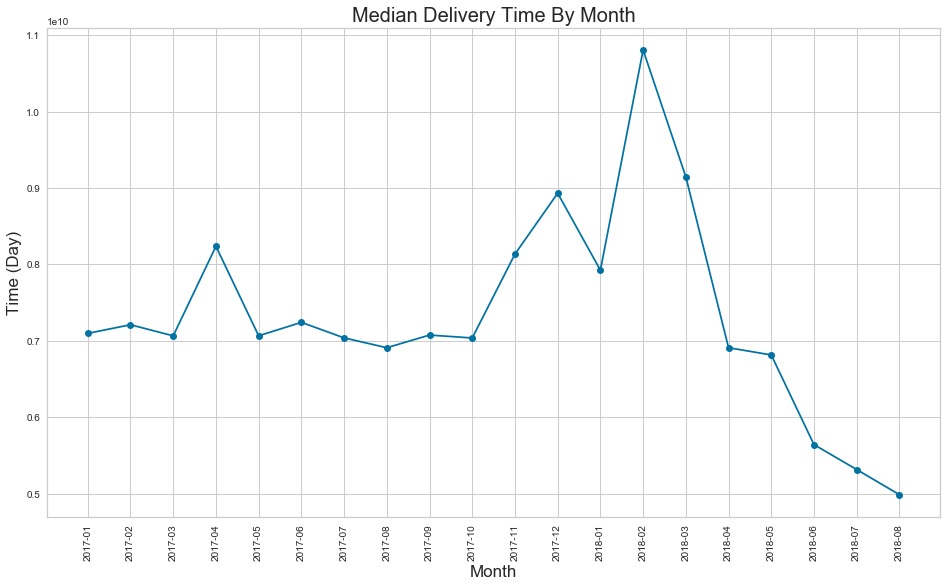

In [36]:
# ¿Cuál es el tiempo de entrega promedio requerido para cada primer pedido?
delivery_time_by_month = all_data['order_delivery_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta


fig=plt.figure(figsize=(16,9))
plt.plot(delivery_time_by_month.index, delivery_time_by_month.values / 86400, marker='o')
plt.title('Median Delivery Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Time (Day)',fontsize=17)

Text(0, 0.5, 'Time (Day)')

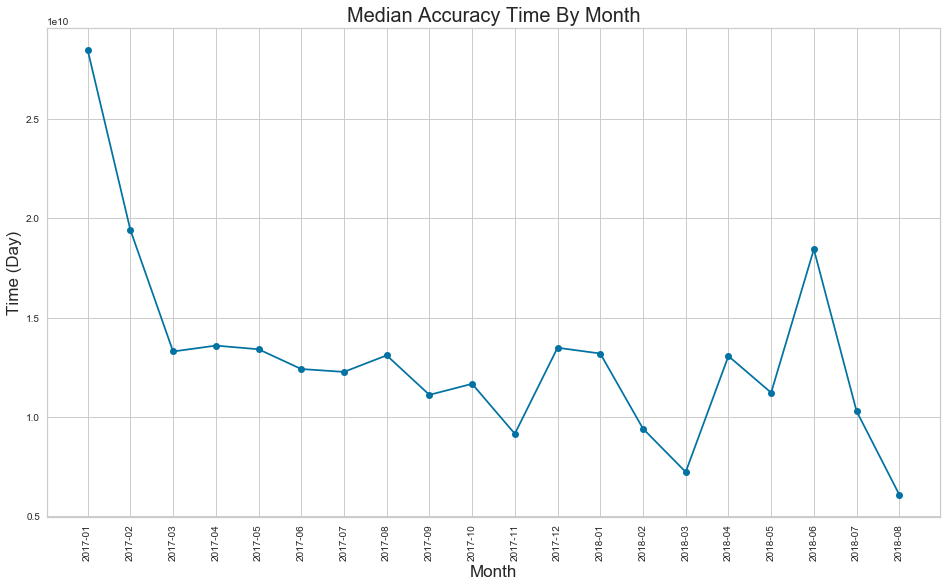

In [37]:
# ¿Cuál es la precisión media del tiempo de los envíos estimados y hasta el cliente en cada pedido mensual?
accuracy_time_by_month = all_data['order_accuracy_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

fig=plt.figure(figsize=(16,9))
plt.plot(accuracy_time_by_month.index, accuracy_time_by_month.values / 86400, marker='o')
plt.title('Median Accuracy Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Time (Day)',fontsize=17)

Text(0, 0.5, 'Time (Minutes)')

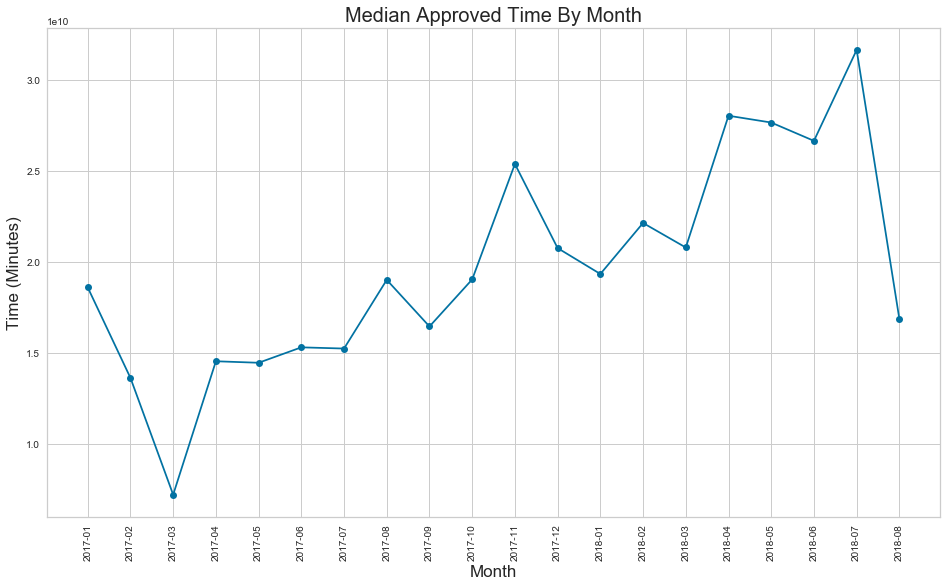

In [38]:
# ¿Cuál es el período de tiempo promedio hasta que se aprueba desde el momento del pedido en cada pedido mensual?
approved_time_by_month = all_data['order_approved_time'].groupby(all_data['Month_order']).median(numeric_only=False) #masukan argumen numeric_only untuk menghitung timedelta

fig=plt.figure(figsize=(16,9))
plt.plot(approved_time_by_month.index, approved_time_by_month.values / 60, marker='o')
plt.title('Median Approved Time By Month',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(#[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
          rotation=90)
plt.ylabel('Time (Minutes)',fontsize=17)

Text(0, 0.5, 'Product Category')

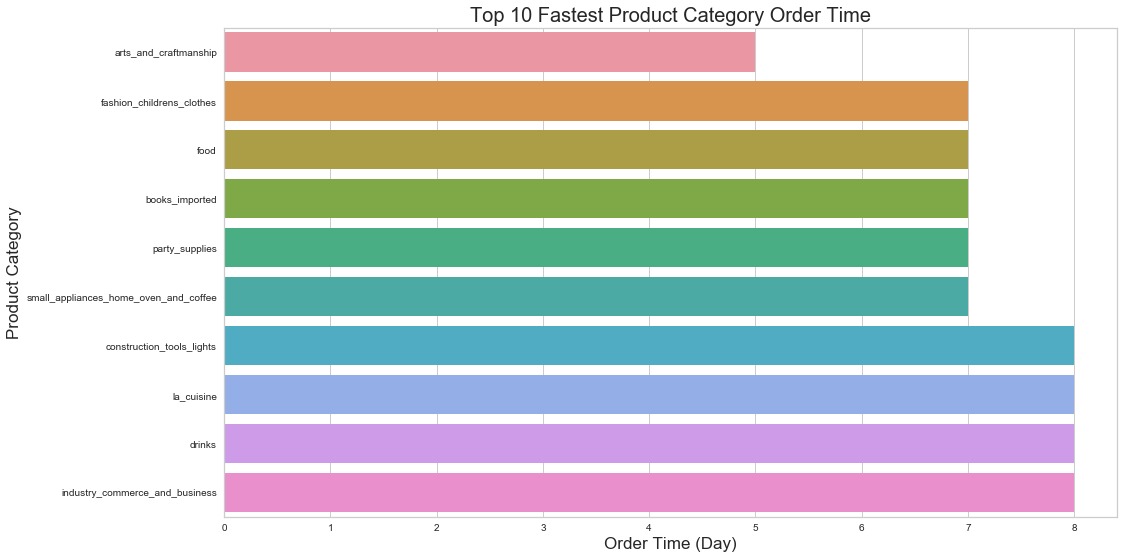

In [39]:
# 10 categorías de productos con el tiempo más rápido desde el pedido hasta la aceptación del cliente
order_time_by_category = pd.DataFrame(all_data['order_process_time'].groupby(all_data['product_category_name_english']).median(numeric_only=False).sort_values(ascending=True)[:10])

fig=plt.figure(figsize=(16,9))
sns.barplot(y=order_time_by_category.index, x=order_time_by_category['order_process_time'].dt.days)
plt.title('Top 10 Fastest Product Category Order Time',fontsize=20)
plt.xlabel('Order Time (Day)',fontsize=17)
plt.ylabel('Product Category',fontsize=17)

Text(0, 0.5, 'Product Category')

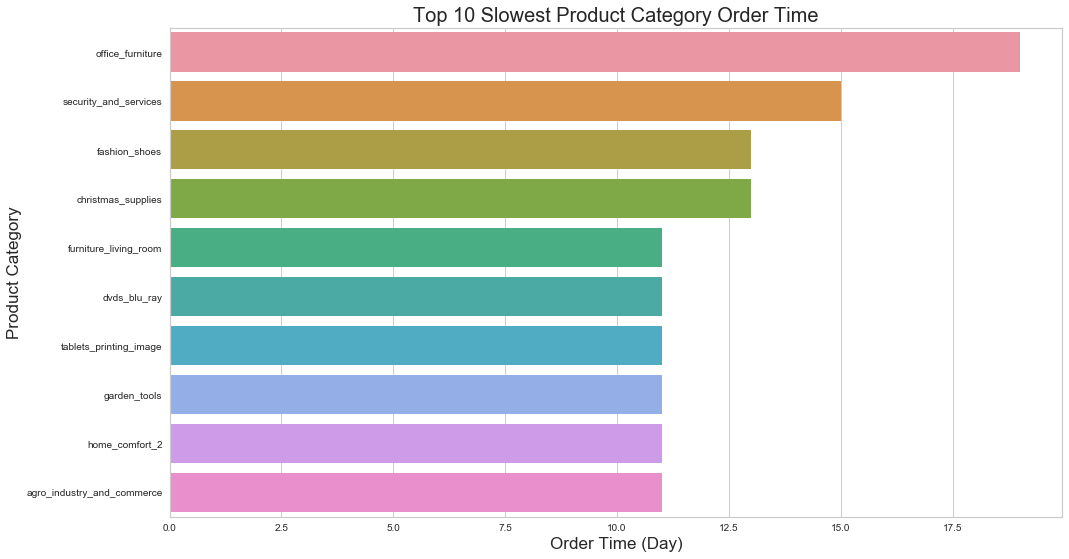

In [40]:
# 10 categorías de productos con el mayor tiempo desde el pedido hasta la aceptación del cliente
order_time_by_category = pd.DataFrame(all_data['order_process_time'].groupby(all_data['product_category_name_english']).median(numeric_only=False).sort_values(ascending=False)[:10])

fig=plt.figure(figsize=(16,9))
sns.barplot(y=order_time_by_category.index, x=order_time_by_category['order_process_time'].dt.days)
plt.title('Top 10 Slowest Product Category Order Time',fontsize=20)
plt.xlabel('Order Time (Day)',fontsize=17)
plt.ylabel('Product Category',fontsize=17)

Text(0, 0.5, 'Amount Order')

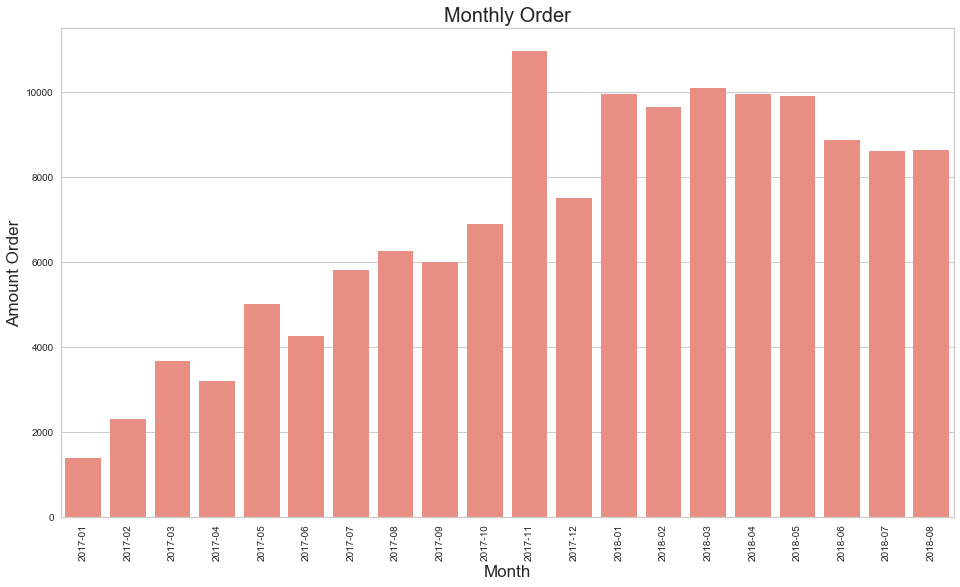

In [41]:
# ¿Cuánto cuesta el pedido cada mes?
order_count_by_month = all_data['order_item_id'].groupby(all_data['Month_order']).sum()

fig=plt.figure(figsize=(16,9))
sns.barplot(y=order_count_by_month.values, x=order_count_by_month.index, color="Salmon")
plt.title('Monthly Order',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Amount Order',fontsize=17)

Text(0, 0.5, 'Amount Revenue')

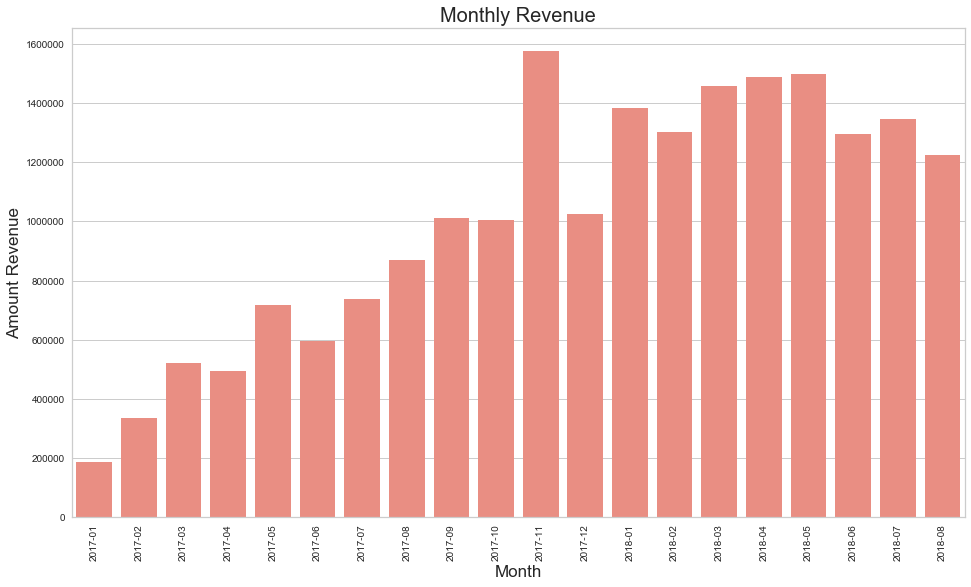

In [42]:
# ¿Cuánto es el ingreso mensual?
revenue_count_by_month = all_data['payment_value'].groupby(all_data['Month_order']).sum()

fig=plt.figure(figsize=(16,9))
sns.barplot(y=revenue_count_by_month.values, x=revenue_count_by_month.index, color="Salmon")
plt.title('Monthly Revenue',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Amount Revenue',fontsize=17)

Text(0, 0.5, 'Amount of User')

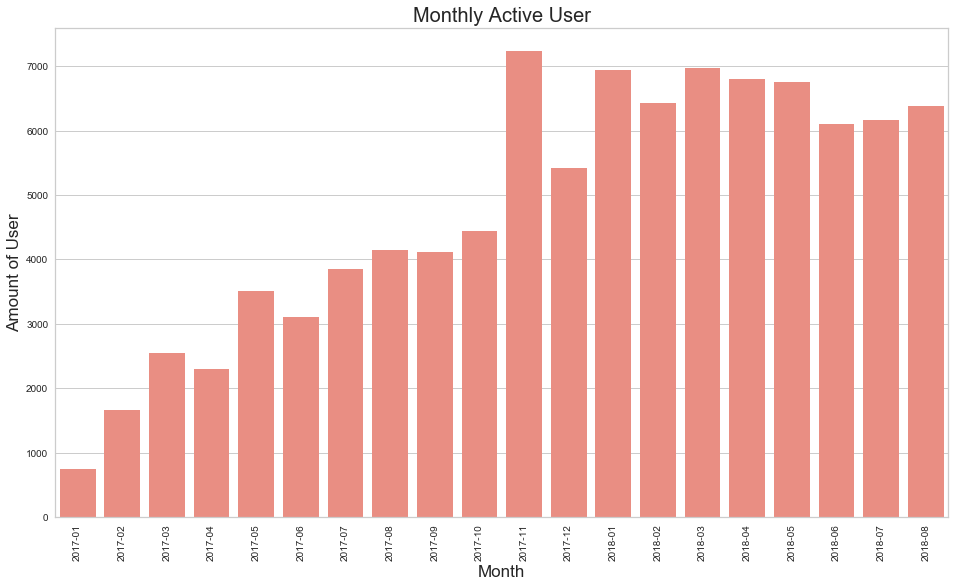

In [43]:
# ¿Cómo son los clientes activos cada mes?
customer_active_by_month = all_data.groupby('Month_order')['customer_unique_id'].nunique().reset_index()

fig=plt.figure(figsize=(16,9))
sns.barplot(y=customer_active_by_month['customer_unique_id'], x=customer_active_by_month['Month_order'], color="Salmon")
plt.title('Monthly Active User',fontsize=20)
plt.xlabel('Month',fontsize=17)
plt.xticks(rotation=90)
plt.ylabel('Amount of User',fontsize=17)

# ** 3. Modelado **

En esta etapa, el modelado se llevará a cabo utilizando un algoritmo de agrupamiento denominado K-Means basado en el análisis RFM (Recency, Frequency, and Monetary) para la segmentación de clientes.

## ** 3.1 Análisis RFM **

El análisis RFM es un método utilizado para ver patrones en los clientes en función de sus hábitos de compra:

1. Recency = ¿Cuándo fue la última vez que el cliente realizó una transacción?
 
2. Frecuencia = ¿Con qué frecuencia el cliente realiza una compra?

3. Monetario = cuánto gastan los clientes

In [44]:
#ver las fechas de compra e inicio
print('Min : {}, Max : {}'.format(min(all_data.order_purchase_timestamp), max(all_data.order_purchase_timestamp)))

Min : 2017-01-05 11:56:06, Max : 2018-08-29 15:00:37


In [45]:
#Calcular RFM
import datetime as dt
pin_date = max(all_data.order_purchase_timestamp) + dt.timedelta(1)

#Creo un dataframe para RFM
rfm = all_data.groupby('customer_unique_id').agg({
    'order_purchase_timestamp' : lambda x: (pin_date - x.max()).days,
    'order_item_id' : 'count', 
    'payment_value' : 'sum'})
#este dataframe va a contener hace cuantos dias hicieron la ultima compra, cuantos productos compraron en el periodo
#bajo estudio y cuanto gastaron en esos productos, en el mismo periodo

rfm.rename(columns = {'order_purchase_timestamp' : 'Recency', 
                      'order_item_id' : 'Frequency', 
                      'payment_value' : 'Monetary'}, inplace = True)

rfm.head()

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19
0000f46a3911fa3c0805444483337064,537,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62
0004aac84e0df4da2b147fca70cf8255,288,1,196.89


## ** 3.2 Manejo de valores atípicos **

En esta etapa, limpiaremos los datos de las entradas que pueden ser incorrectas o las anomalías de los datos que tenemos.

In [46]:
#Usamos Rangos intercuartilicos
def limit(i):
    Q1 = rfm[i].quantile(0.5)
    Q3 = rfm[i].quantile(0.95)
    IQR = Q3 - Q1
    
    
    lower_limit = rfm[i].quantile(0.5) - (IQR * 1.5)
    lower_limit_extreme = rfm[i].quantile(0.5) - (IQR * 3)
    upper_limit = rfm[i].quantile(0.95) + (IQR * 1.5)
    upper_limit_extreme = rfm[i].quantile(0.5) + (IQR * 3)
    print('Lower Limit:', lower_limit)
    print('Lower Limit Extreme:', lower_limit_extreme)
    print('Upper Limit:', upper_limit)
    print('Upper Limit Extreme:', upper_limit_extreme)

def percent_outliers(i):
    Q1 = rfm[i].quantile(0.5)
    Q3 = rfm[i].quantile(0.95)
    IQR = Q3 - Q1
    
    lower_limit = rfm[i].quantile(0.5) - (IQR * 1.5)
    lower_limit_extreme = rfm[i].quantile(0.5) - (IQR * 3)
    upper_limit = rfm[i].quantile(0.95) + (IQR * 1.5)
    upper_limit_extreme = rfm[i].quantile(0.95) + (IQR * 3)
    print('Lower Limit: {} %'.format(rfm[(rfm[i] >= lower_limit)].shape[0]/ rfm.shape[0]*100))
    print('Lower Limit Extereme: {} %'.format(rfm[(rfm[i] >= lower_limit_extreme)].shape[0]/rfm.shape[0]*100))
    print('Upper Limit: {} %'.format(rfm[(rfm[i] >= upper_limit)].shape[0]/ rfm.shape[0]*100))
    print('Upper Limit Extereme: {} %'.format(rfm[(rfm[i] >= upper_limit_extreme)].shape[0]/rfm.shape[0]*100))

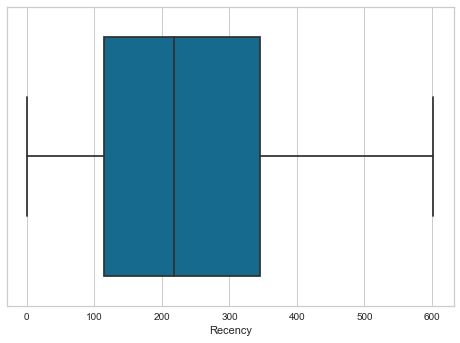

In [47]:
sns.boxplot(x=rfm["Recency"])

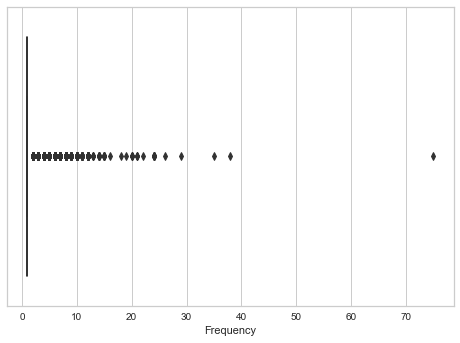

In [48]:
sns.boxplot(x=rfm["Frequency"])

La columna Frecuencia no elimina los valores atípicos porque los valores atípicos aquí son de hecho la posibilidad de que los clientes realicen muchas transacciones porque estos datos se toman de 2017-2018

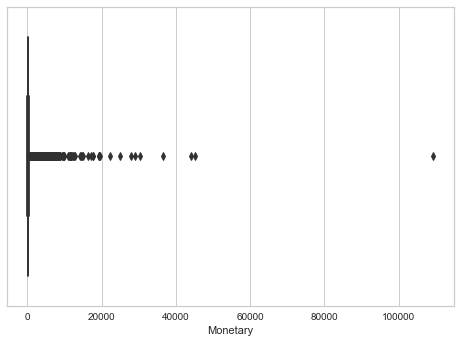

In [49]:
sns.boxplot(x=rfm["Monetary"])

In [50]:
print(limit('Monetary'))
print('-'*50)
print(percent_outliers('Monetary'))

Lower Limit: -719.16
Lower Limit Extreme: -1551.4499999999998
Upper Limit: 1500.28
Upper Limit Extreme: 1777.71
None
--------------------------------------------------
Lower Limit: 100.0 %
Lower Limit Extereme: 100.0 %
Upper Limit: 1.2549312293421473 %
Upper Limit Extereme: 0.5363045100757011 %
None


In [51]:
#se eliminan los valores outliers de aquellos que hayan gastado mas de 1500 
outliers1_drop = rfm[(rfm['Monetary'] > 1500)].index
rfm.drop(outliers1_drop, inplace=True)

## ** 3.3 Percentil RFM **

En esta etapa, se crearán grupos de clientes basados ​​en Recency, Frequency y Monetary dividiéndolos en grupos de 3 **** en cada uno.

In [52]:
# Crear grupos de clientes basados en Recency, Frequency y Monetary
#Porque en Recency cuantos menos días pasaron desde la ultima compra mejor
r_labels = range(3, 0, -1)
r_groups = pd.qcut(rfm.Recency, q = 3, labels = r_labels).astype('int')

# Debido a que en la frecuencia vemos muchos valores igual a 1, entonces no puede usar qcut,
#porque el valor se apoyará más
f_groups = pd.qcut(rfm.Frequency.rank(method='first'), 3).astype('str')
#rfm['F'] = np.where((rfm['Frequency'] != 1) & (rfm['Frequency'] != 2), 3, rfm.Frequency)

m_labels = range(1, 4)
m_groups = pd.qcut(rfm.Monetary, q = 3, labels = m_labels).astype('int')

In [53]:
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values

In [54]:
rfm['F'].value_counts()

(0.999, 30871.333]        30871
(61741.667, 92612.0]      30871
(30871.333, 61741.667]    30870
Name: F, dtype: int64

In [55]:
rfm['F'] = rfm['F'].replace({'(0.999, 30871.333]' : 1,
                             '(30871.333, 61741.667]' : 2,
                             '(61741.667, 92612.0]' : 3}).astype('int')

In [56]:
rfm['RFM_Segment'] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
customer_unique_id,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,3,1,2,3.01.02.0,6
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,3.01.01.0,5
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,1.01.02.0,4
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,1,1,1,1.01.01.0,3
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3,2.01.03.0,6


In [57]:
score_labels = ['Bronze', 'Silver', 'Gold']
score_groups = pd.qcut(rfm.RFM_Score, q=3, labels = score_labels)
rfm['RFM_Level'] = score_groups.values
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,3,1,2,3.01.02.0,6,Silver
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,3.01.01.0,5,Bronze
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,1.01.02.0,4,Bronze
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,1,1,1,1.01.01.0,3,Bronze
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3,2.01.03.0,6,Silver


## ** 3.4 Manejo de la inclinación y el escalado **

Para los datos que ingresarán al algoritmo K-Means, la distribución es normal porque facilitará la formación de grupos, luego no olvides igualar la escala de cada columna porque se medirá en función de la distancia entre cada entrada.

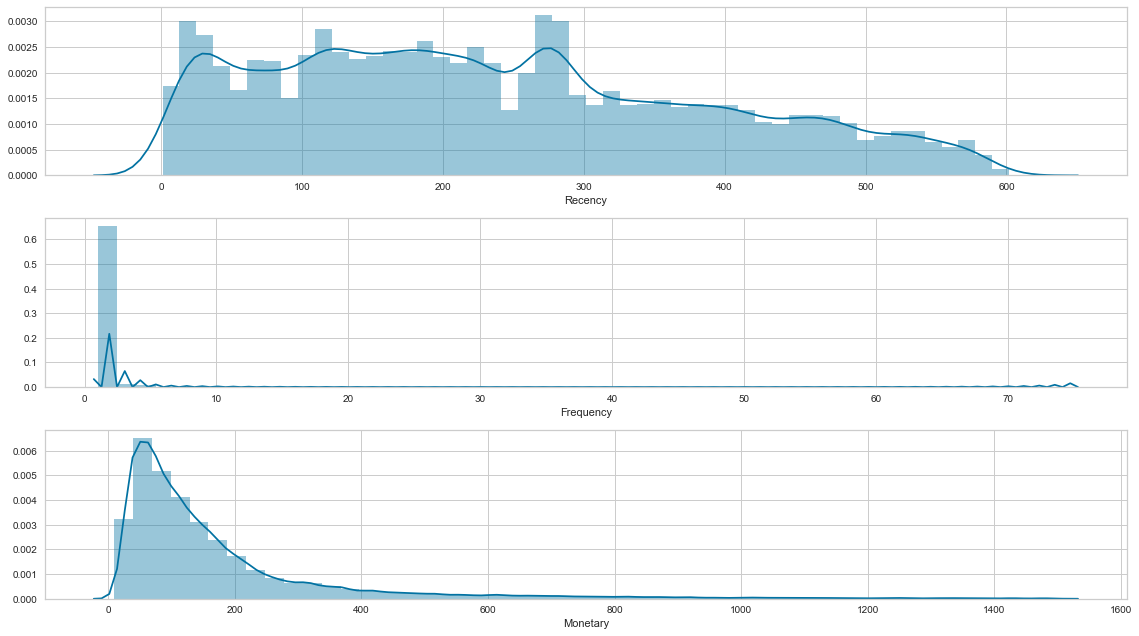

In [58]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.subplot(3, 1, 1); sns.distplot(rfm.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'], kde_kws={'bw': 0.1}, label='Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm.Monetary, label = 'Monetary')

plt.tight_layout()
plt.show()

In [59]:
from scipy import stats

rfm_log = rfm[['Recency', 'Monetary']].apply(np.log, axis = 1).round(3)
rfm_log['Frequency'] = stats.boxcox(rfm['Frequency'])[0]
rfm_log.head()

,Recency,Monetary,Frequency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,4.718,4.955,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,4.745,3.303,0.0
0000f46a3911fa3c0805444483337064,6.286,4.457,0.0
0000f6ccb0745a6a4b88665a16c9f078,5.771,3.776,0.0
0004aac84e0df4da2b147fca70cf8255,5.663,5.283,0.0


In [60]:
scaler = StandardScaler()
minmax = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

In [61]:
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)
rfm_scaled.head()

,Recency,Monetary,Frequency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.456069,0.220580,-0.408549
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.427655,-1.712288,-0.408549
0000f46a3911fa3c0805444483337064,1.194001,-0.362089,-0.408549
0000f6ccb0745a6a4b88665a16c9f078,0.652046,-1.158870,-0.408549
0004aac84e0df4da2b147fca70cf8255,0.538393,0.604345,-0.408549


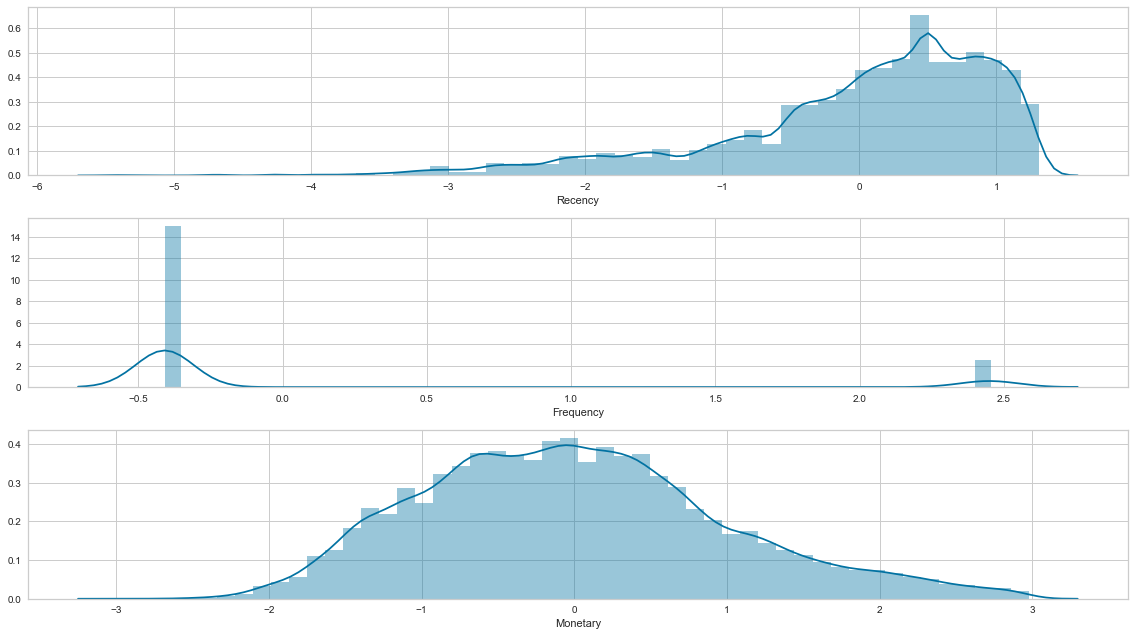

In [62]:
fig, ax = plt.subplots(figsize=(16, 9))
plt.subplot(3, 1, 1); sns.distplot(rfm_scaled.Recency, label = 'Recency')
plt.subplot(3, 1, 2); sns.distplot(rfm_scaled.Frequency, kde_kws={'bw': 0.1}, label='Frequency')
plt.subplot(3, 1, 3); sns.distplot(rfm_scaled.Monetary, label = 'Monetary')

plt.tight_layout()
plt.show()

## ** 3.5 Agrupamiento de K-Means **

Aquí la agrupación se realizará utilizando el algoritmo K-Means para obtener el grupo óptimo de datos RFM

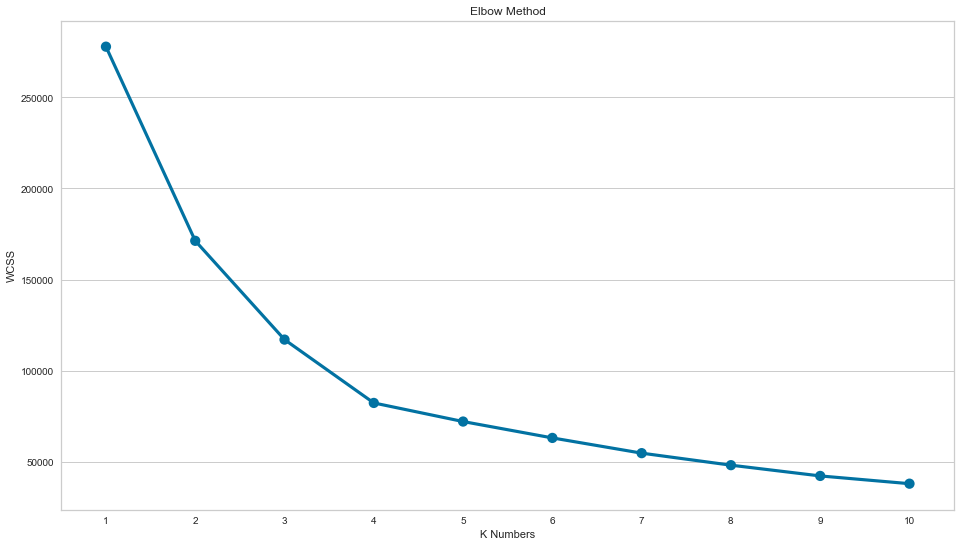

In [63]:
wcss = {}

for i in range(1, 11):
    kmeans = KMeans(n_clusters= i, init= 'k-means++', max_iter= 300)
    kmeans.fit(rfm_scaled)
    wcss[i] = kmeans.inertia_
    
fig, ax = plt.subplots(figsize=(16, 9))
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.title('Elbow Method')
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

In [64]:
clus = KMeans(n_clusters= 3, n_init=10, init= 'k-means++', max_iter= 300)
clus.fit(rfm_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [65]:
rfm['K_Cluster'] = clus.labels_
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,3,1,2,3.01.02.0,6,Silver,0
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,3.01.01.0,5,Bronze,0
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,1.01.02.0,4,Bronze,0
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,1,1,1,1.01.01.0,3,Bronze,0
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3,2.01.03.0,6,Silver,0


## ** 3.6 Evaluación **

Después de crear un modelo usando KMeans, ahora evaluaremos el modelo si los grupos que forma son realmente diferentes de cada grupo usando el Análisis de Silhouuette. Cuanto más se acerca al número 1, la diferencia que tiene con otras computadoras es cada vez más clara, si el valor está cerca de 0, entonces se parece cada vez más a un grupo cercano y, si -1, hizo un grupo incorrecto.

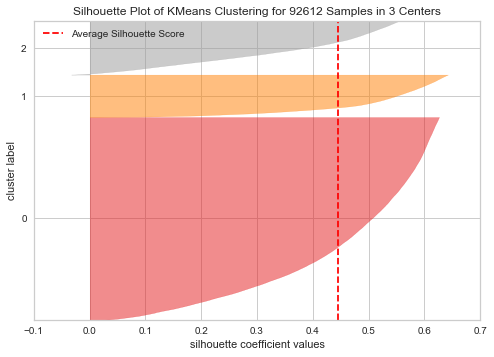

In [66]:
visualizer = SilhouetteVisualizer(clus)

visualizer.fit(rfm_scaled) 
visualizer.poof() 

## ** 3.5 Visualización **

Visualizaremos para que sea más fácil ver el clúster que creamos con el clúster del algoritmo KMeans. Usaremos 'Snake Plot' en el mundo del marketing para ver qué categorías se incluyen en un clúster.



In [67]:
rfm_scaled['K_Cluster'] = clus.labels_
rfm_scaled['RFM_Level'] = rfm.RFM_Level
rfm_scaled.reset_index(inplace = True)
rfm_scaled.head()

,customer_unique_id,Recency,Monetary,Frequency,K_Cluster,RFM_Level
0,0000366f3b9a7992bf8c76cfdf3221e2,-0.456069,0.220580,-0.408549,0,Silver
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-0.427655,-1.712288,-0.408549,0,Bronze
2,0000f46a3911fa3c0805444483337064,1.194001,-0.362089,-0.408549,0,Bronze
3,0000f6ccb0745a6a4b88665a16c9f078,0.652046,-1.158870,-0.408549,0,Bronze
4,0004aac84e0df4da2b147fca70cf8255,0.538393,0.604345,-0.408549,0,Silver


In [68]:
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['customer_unique_id', 'RFM_Level', 'K_Cluster'], 
                     var_name = 'Metrics', value_name = 'Value')
rfm_melted.head()

,customer_unique_id,RFM_Level,K_Cluster,Metrics,Value
0,0000366f3b9a7992bf8c76cfdf3221e2,Silver,0,Recency,-0.456069
1,0000b849f77a49e4a4ce2b2a4ca5be3f,Bronze,0,Recency,-0.427655
2,0000f46a3911fa3c0805444483337064,Bronze,0,Recency,1.194001
3,0000f6ccb0745a6a4b88665a16c9f078,Bronze,0,Recency,0.652046
4,0004aac84e0df4da2b147fca70cf8255,Silver,0,Recency,0.538393


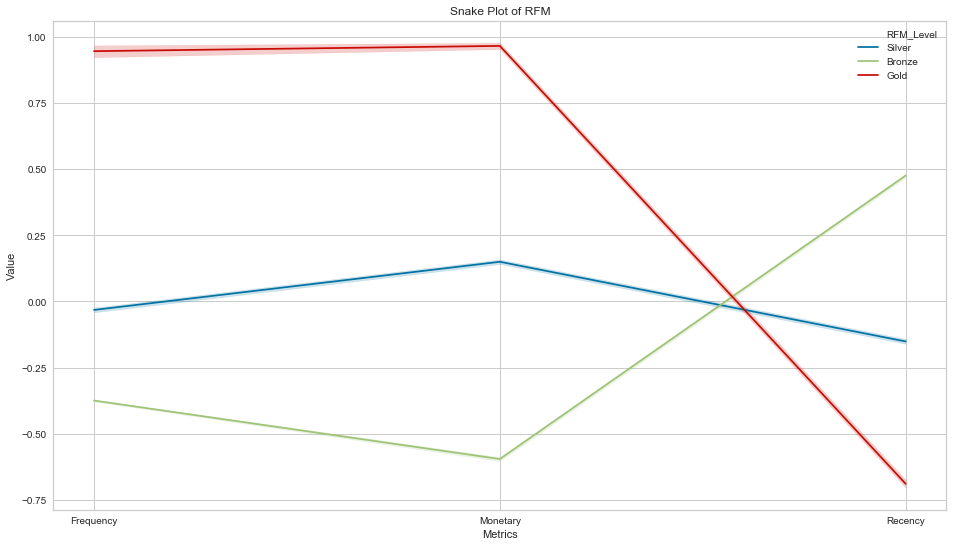

In [69]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

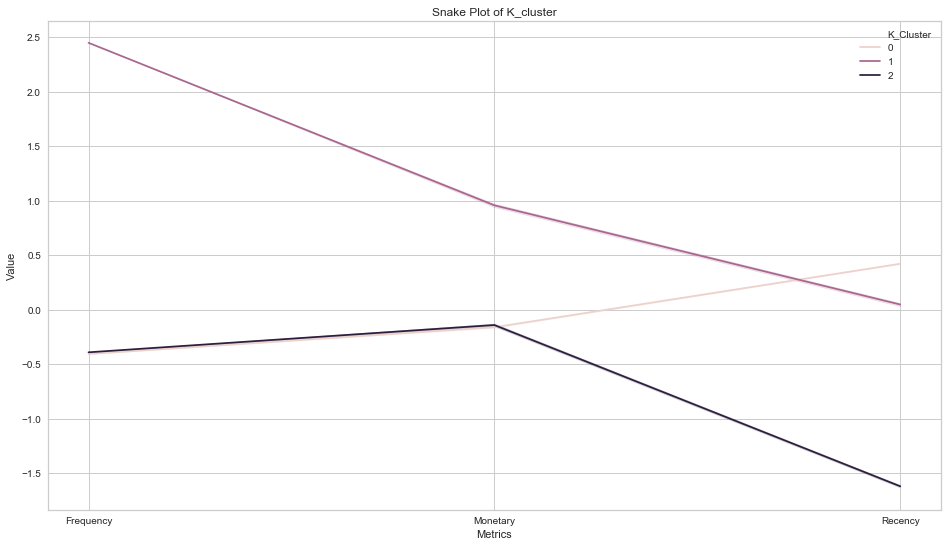

In [70]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster', data = rfm_melted)
plt.title('Snake Plot of K_cluster')
plt.legend(loc = 'upper right')

Como podemos ver en los dos gráficos anteriores, podemos concluir con base en grupos:
1. Bronce (1 y 0): la frecuencia no es demasiado alta en comparación con la transacción nominal, pero la última vez que realizó una transacción rápida
2. Plata (2): la frecuencia es bastante alta y la transacción nominal es bastante alta, pero la última vez que realizó una transacción fue bastante larga
3. Oro (3): la frecuencia de gasto es alta y la cantidad gastada también es alta, pero el tiempo de transacción es largo

Text(0, 0.5, 'Amount of Customer')

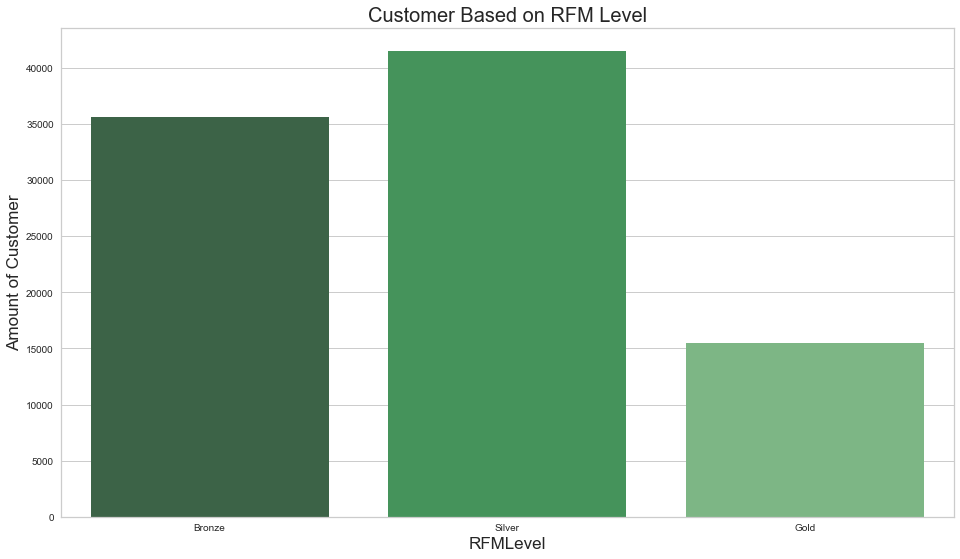

In [71]:
# ¿Cuántos clientes hay según su categoría?
rfm_cus_level = rfm_scaled.groupby('RFM_Level')['customer_unique_id'].nunique().reset_index()


fig=plt.figure(figsize=(16,9))
sns.barplot(y=rfm_cus_level['customer_unique_id'], x=rfm_cus_level['RFM_Level'], palette="Greens_d")
plt.title('Customer Based on RFM Level',fontsize=20)
plt.xlabel('RFMLevel',fontsize=17)
plt.ylabel('Amount of Customer',fontsize=17)

# ** 4. CONCLUSIÓN**

En cuanto a los objetivos de este proyecto, que es facilitar que el departamento de marketing lleve a cabo campañas o promociones basadas en la segmentación de clientes, estas son las conclusiones:

1. Bronce: un cliente que no realiza compras con demasiada frecuencia y el valor nominal de la transacción es bajo, pero la última vez que realizó una transacción rápida. Hay 36,000 clientes de este tipo.
    - Acción: puede probarse dando descuentos u ofertas con un precio nominal asequible para que la tasa de conversión aumente porque el número de clientes de la categoría Bronce es bastante
2. Plata: Clientes que con frecuencia realizan compras y la transacción nominal es bastante alta, pero la última vez que realiza transacciones es bastante larga. Hay 42,000 clientes de este tipo.
    - Acción: dada una combinación de descuentos y campañas después de la transacción para aumentar las compras mediante el uso de un correo electrónico personalizado que puede dar un toque personal.
3. Oro: Clientes que a menudo compran y también realizan muchas transacciones nominales, pero el último tiempo de transacción es largo. Hay 15000 clientes de este tipo.
    - Acción: se suele dar una campaña después de realizar una transacción para volver a realizar una compra. También podría ser recompensado porque con mayor frecuencia realizan transacciones y el valor nominal es alto.



Ahora haremos un analisis similar al anterior pero con 4 clusters k=4

In [75]:
#Crearemos grupos teniendo en cuenta recency, frecuency y monetary diviendolos en grupos de 4 

# Crear grupos de clientes basados en Recency, Frequency y Monetary
#En Recency cuantos menos días pasaron desde la ultima compra mejor es
r_labels = range(4, 0, -1)
r_groups = pd.qcut(rfm.Recency, q = 4, labels = r_labels).astype('int')

f_groups = pd.qcut(rfm.Frequency.rank(method='first'), 4).astype('str')

m_labels = range(1, 5)
m_groups = pd.qcut(rfm.Monetary, q = 4, labels = m_labels).astype('int')

In [76]:
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values

In [77]:
rfm['F'].value_counts()

(0.999, 23153.75]      23153
(69459.25, 92612.0]    23153
(23153.75, 46306.5]    23153
(46306.5, 69459.25]    23153
Name: F, dtype: int64

In [79]:
#reemplazaremos los raangos por los valores 1, 2, 3 y 4 
rfm['F'] = rfm['F'].replace({'(0.999, 23153.75]' : 1,
                             '(69459.25, 92612.0]' : 2,
                             '(23153.75, 46306.5]' : 3,
                             '(46306.5, 69459.25]' : 4}).astype('int')

In [80]:
rfm['RFM_Segment'] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,3,413,8,Silver,0
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,311,5,Bronze,0
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,112,4,Bronze,0
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1,211,4,Bronze,0
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3,213,6,Silver,0


In [81]:
score_labels = ['Bronze', 'Silver', 'Gold', 'Platinum']
score_groups = pd.qcut(rfm.RFM_Score, q=4, labels = score_labels)
rfm['RFM_Level'] = score_groups.values
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,3,413,8,Silver,0
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,311,5,Bronze,0
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,112,4,Bronze,0
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1,211,4,Bronze,0
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3,213,6,Bronze,0


In [83]:
#Inclinacion y escalonado 

rfm_log = rfm[['Recency', 'Monetary']].apply(np.log, axis = 1).round(4)
rfm_log['Frequency'] = stats.boxcox(rfm['Frequency'])[0]
rfm_log.head()

,Recency,Monetary,Frequency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,4.7185,4.9551,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,4.7449,3.3028,0.0
0000f46a3911fa3c0805444483337064,6.2860,4.4569,0.0
0000f6ccb0745a6a4b88665a16c9f078,5.7714,3.7755,0.0
0004aac84e0df4da2b147fca70cf8255,5.6630,5.2826,0.0


In [84]:
scaler = StandardScaler()
minmax = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)
rfm_scaled.head()

,Recency,Monetary,Frequency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.455564,0.220701,-0.408549
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.427783,-1.712509,-0.408549
0000f46a3911fa3c0805444483337064,1.193975,-0.362199,-0.408549
0000f6ccb0745a6a4b88665a16c9f078,0.652442,-1.159445,-0.408549
0004aac84e0df4da2b147fca70cf8255,0.538369,0.603880,-0.408549


In [85]:
#Agrupamiento de clusters 
clus = KMeans(n_clusters= 4, n_init=10, init= 'k-means++', max_iter= 300)
clus.fit(rfm_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [86]:
rfm['K_Cluster'] = clus.labels_
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,3,413,8,Silver,0
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,3,1,1,311,5,Bronze,1
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,112,4,Bronze,1
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1,211,4,Bronze,1
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,3,213,6,Bronze,0


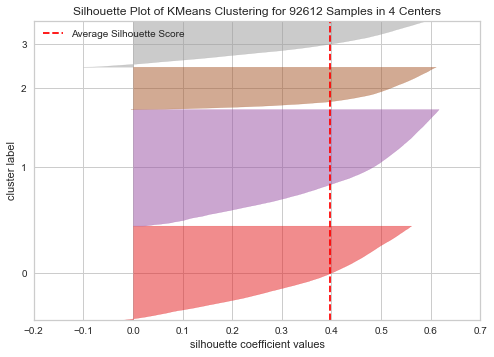

In [87]:
#Evaluacion
#Evaluaremos el modelo utilizando el metodo de la silueta 

visualizer = SilhouetteVisualizer(clus)

visualizer.fit(rfm_scaled) 
visualizer.poof() 

In [88]:
##Visualizacion de los clusters

rfm_scaled['K_Cluster'] = clus.labels_
rfm_scaled['RFM_Level'] = rfm.RFM_Level
rfm_scaled.reset_index(inplace = True)
rfm_scaled.head()

,customer_unique_id,Recency,Monetary,Frequency,K_Cluster,RFM_Level
0,0000366f3b9a7992bf8c76cfdf3221e2,-0.455564,0.220701,-0.408549,0,Silver
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-0.427783,-1.712509,-0.408549,1,Bronze
2,0000f46a3911fa3c0805444483337064,1.193975,-0.362199,-0.408549,1,Bronze
3,0000f6ccb0745a6a4b88665a16c9f078,0.652442,-1.159445,-0.408549,1,Bronze
4,0004aac84e0df4da2b147fca70cf8255,0.538369,0.603880,-0.408549,0,Bronze


In [89]:
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['customer_unique_id', 'RFM_Level', 'K_Cluster'], 
                     var_name = 'Metrics', value_name = 'Value')
rfm_melted.head()

,customer_unique_id,RFM_Level,K_Cluster,Metrics,Value
0,0000366f3b9a7992bf8c76cfdf3221e2,Silver,0,Recency,-0.455564
1,0000b849f77a49e4a4ce2b2a4ca5be3f,Bronze,1,Recency,-0.427783
2,0000f46a3911fa3c0805444483337064,Bronze,1,Recency,1.193975
3,0000f6ccb0745a6a4b88665a16c9f078,Bronze,1,Recency,0.652442
4,0004aac84e0df4da2b147fca70cf8255,Bronze,0,Recency,0.538369


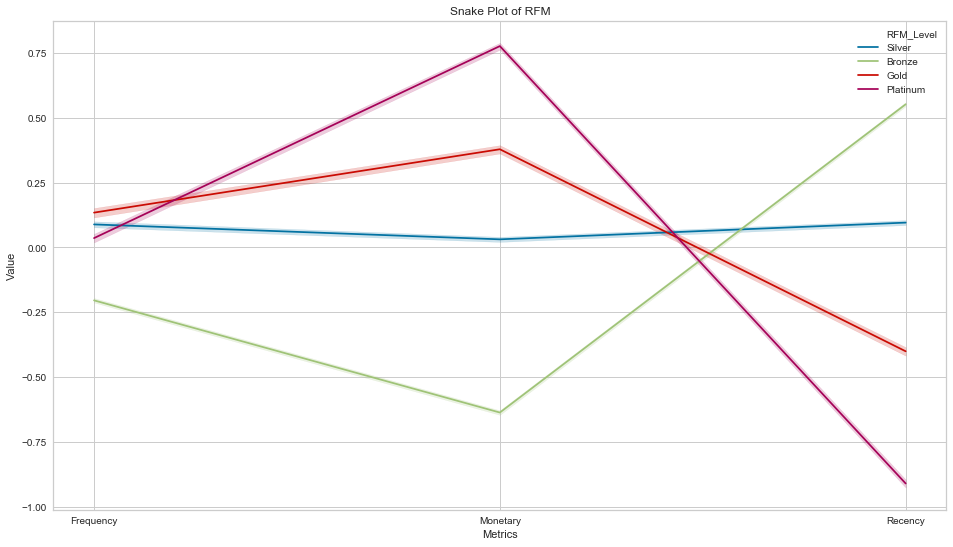

In [90]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

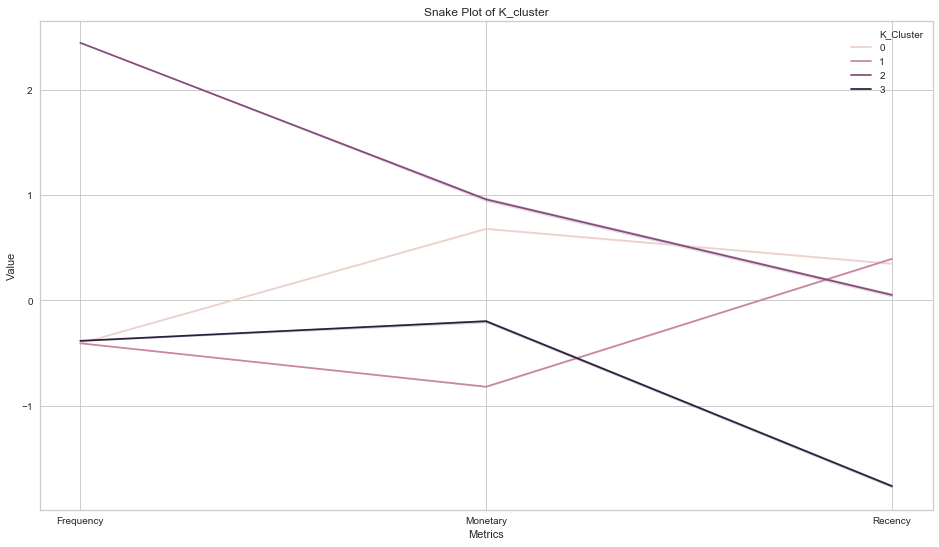

In [91]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster', data = rfm_melted)
plt.title('Snake Plot of K_cluster')
plt.legend(loc = 'upper right')

conclusion de lo observado en los graficos anteriores 
1. Grupo platinum: podemos observar que la frecuencia de compra es media alta, pero el valor monetario es muy alto y la ultima vez que compro fue hace muy poco 
2. Grupo gold: la frecuencia en que compra es alta, el valor monetario gastado es medio alto (menor al grupo platinum) y compro hace medianamente poco por ultima vez 
3. Grupo silver: compra con una frecuencia media baja, tiene gastos medios tambien y la ultima compro la realizo hace mucho 
4. Grupo bronze: la frecuencia con que compran y el valor monetario son muy bajos, y hace mucho mas tiempo que cualquier otro grupo que realizo la ultima compra 

Text(0, 0.5, 'Amount of Customer')

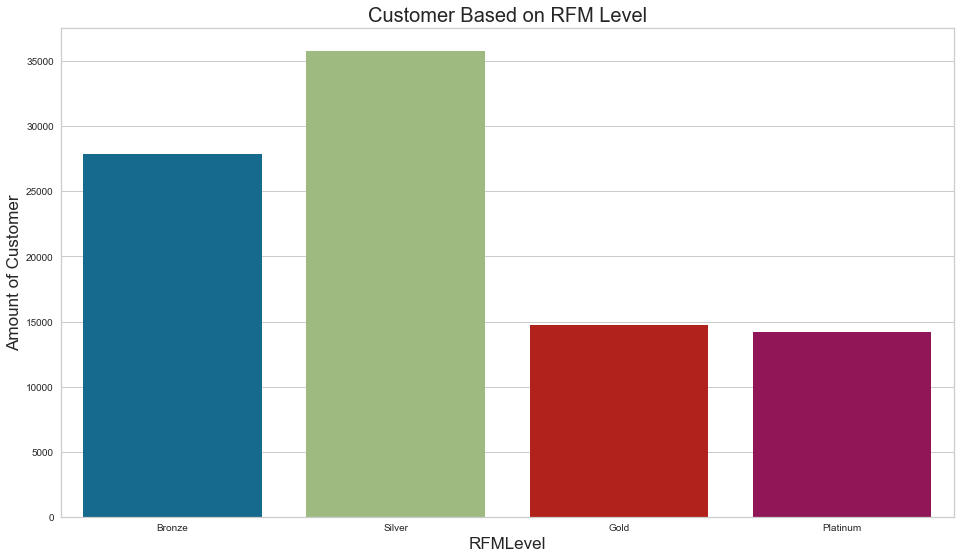

In [92]:
# ¿Cuántos clientes hay según su categoría?
rfm_cus_level = rfm_scaled.groupby('RFM_Level')['customer_unique_id'].nunique().reset_index()


fig=plt.figure(figsize=(16,9))
sns.barplot(y=rfm_cus_level['customer_unique_id'], x=rfm_cus_level['RFM_Level'])
plt.title('Customer Based on RFM Level',fontsize=20)
plt.xlabel('RFMLevel',fontsize=17)
plt.ylabel('Amount of Customer',fontsize=17)

In [93]:
#conclusion con 4 clusters y acciones de campaña a realizar

In [94]:
#Por ultimo realizaremos el mismo analisis pero para 5 clusters 

#Crearemos grupos teniendo en cuenta recency, frecuency y monetary diviendolos en grupos de 5

# Crear grupos de clientes basados en Recency, Frequency y Monetary
#En Recency cuantos menos días pasaron desde la ultima compra mejor es
r_labels = range(5, 0, -1)
r_groups = pd.qcut(rfm.Recency, q = 5, labels = r_labels).astype('int')

f_groups = pd.qcut(rfm.Frequency.rank(method='first'), 5).astype('str')

m_labels = range(1, 6)
m_groups = pd.qcut(rfm.Monetary, q = 5, labels = m_labels).astype('int')

In [95]:
rfm['R'] = r_groups.values
rfm['F'] = f_groups.values
rfm['M'] = m_groups.values

In [96]:
rfm['F'].value_counts()

(0.999, 18523.2]      18523
(74089.8, 92612.0]    18523
(37045.4, 55567.6]    18522
(55567.6, 74089.8]    18522
(18523.2, 37045.4]    18522
Name: F, dtype: int64

In [97]:
#reemplazaremos los raangos por los valores 1, 2, 3, 4 y 5
rfm['F'] = rfm['F'].replace({'(0.999, 18523.2]' : 1,
                             '(74089.8, 92612.0]' : 2,
                             '(37045.4, 55567.6]' : 3,
                             '(55567.6, 74089.8]' : 4,
                             '(18523.2, 37045.4]' : 5}).astype('int')

In [98]:
rfm['RFM_Segment'] = rfm.apply(lambda x: str(x['R']) + str(x['F']) + str(x['M']), axis = 1)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis = 1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,4,414,9,Silver,0
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,4,1,1,411,6,Bronze,1
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,112,4,Bronze,1
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1,211,4,Bronze,1
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,4,214,7,Bronze,0


In [100]:
#le pondremos nombre a nuestras 5 categorias que representaran los grupos de clientes 
score_labels = ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond']
score_groups = pd.qcut(rfm.RFM_Score, q=5, labels = score_labels)
rfm['RFM_Level'] = score_groups.values
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,4,414,9,Gold,0
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,4,1,1,411,6,Bronze,1
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,112,4,Bronze,1
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1,211,4,Bronze,1
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,4,214,7,Bronze,0


In [101]:
#Inclinacion y escalonado 

rfm_log = rfm[['Recency', 'Monetary']].apply(np.log, axis = 1).round(4)
rfm_log['Frequency'] = stats.boxcox(rfm['Frequency'])[0]
rfm_log.head()

,Recency,Monetary,Frequency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,4.7185,4.9551,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,4.7449,3.3028,0.0
0000f46a3911fa3c0805444483337064,6.2860,4.4569,0.0
0000f6ccb0745a6a4b88665a16c9f078,5.7714,3.7755,0.0
0004aac84e0df4da2b147fca70cf8255,5.6630,5.2826,0.0


In [102]:
scaler = StandardScaler()
minmax = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled = pd.DataFrame(rfm_scaled, index = rfm.index, columns = rfm_log.columns)
rfm_scaled.head()

,Recency,Monetary,Frequency
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,-0.455564,0.220701,-0.408549
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.427783,-1.712509,-0.408549
0000f46a3911fa3c0805444483337064,1.193975,-0.362199,-0.408549
0000f6ccb0745a6a4b88665a16c9f078,0.652442,-1.159445,-0.408549
0004aac84e0df4da2b147fca70cf8255,0.538369,0.603880,-0.408549


In [103]:
#Agrupamiento de clusters 
clus = KMeans(n_clusters= 5, n_init=10, init= 'k-means++', max_iter= 300)
clus.fit(rfm_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [104]:
rfm['K_Cluster'] = clus.labels_
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,RFM_Level,K_Cluster
customer_unique_id,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,4,1,4,414,9,Gold,0
0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,4,1,1,411,6,Bronze,0
0000f46a3911fa3c0805444483337064,537,1,86.22,1,1,2,112,4,Bronze,3
0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,2,1,1,211,4,Bronze,3
0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,4,214,7,Bronze,2


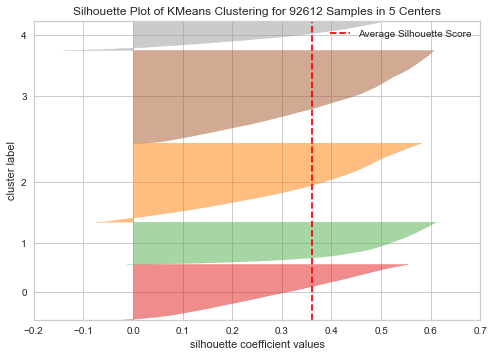

In [105]:
#Evaluacion
#Evaluaremos el modelo utilizando el metodo de la silueta 

visualizer = SilhouetteVisualizer(clus)

visualizer.fit(rfm_scaled) 
visualizer.poof() 

podemos observar que con esta nueva distribucion la nueva agrupacion no es tan buena como las anteriores
el score del metodo de silueta no esta dando menos de 0.4 y los grupos estan siendo muy diferentes entre si 

In [106]:
##Visualizacion de los clusters

rfm_scaled['K_Cluster'] = clus.labels_
rfm_scaled['RFM_Level'] = rfm.RFM_Level
rfm_scaled.reset_index(inplace = True)
rfm_scaled.head()

,customer_unique_id,Recency,Monetary,Frequency,K_Cluster,RFM_Level
0,0000366f3b9a7992bf8c76cfdf3221e2,-0.455564,0.220701,-0.408549,0,Gold
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-0.427783,-1.712509,-0.408549,0,Bronze
2,0000f46a3911fa3c0805444483337064,1.193975,-0.362199,-0.408549,3,Bronze
3,0000f6ccb0745a6a4b88665a16c9f078,0.652442,-1.159445,-0.408549,3,Bronze
4,0004aac84e0df4da2b147fca70cf8255,0.538369,0.603880,-0.408549,2,Bronze


In [107]:
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['customer_unique_id', 'RFM_Level', 'K_Cluster'], 
                     var_name = 'Metrics', value_name = 'Value')
rfm_melted.head()

,customer_unique_id,RFM_Level,K_Cluster,Metrics,Value
0,0000366f3b9a7992bf8c76cfdf3221e2,Gold,0,Recency,-0.455564
1,0000b849f77a49e4a4ce2b2a4ca5be3f,Bronze,0,Recency,-0.427783
2,0000f46a3911fa3c0805444483337064,Bronze,3,Recency,1.193975
3,0000f6ccb0745a6a4b88665a16c9f078,Bronze,3,Recency,0.652442
4,0004aac84e0df4da2b147fca70cf8255,Bronze,2,Recency,0.538369


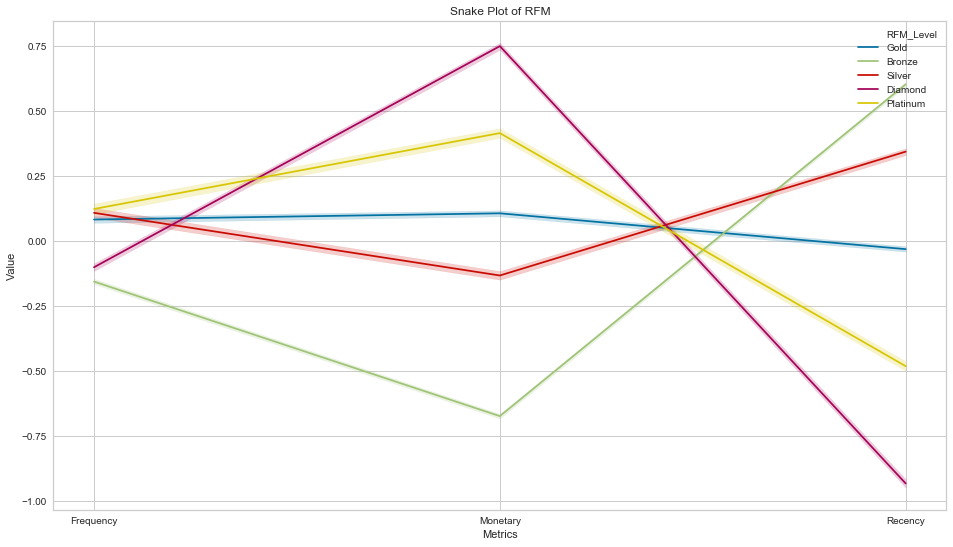

In [108]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'RFM_Level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

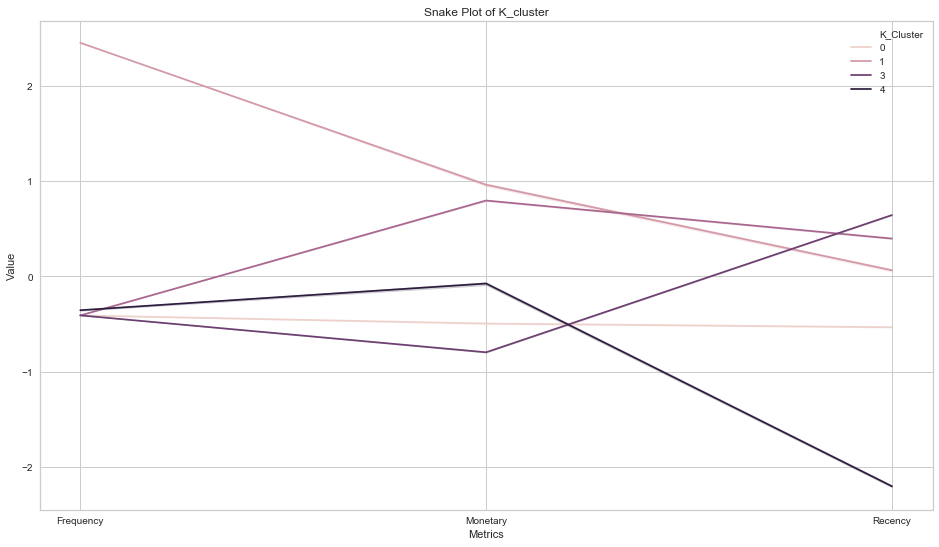

In [109]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.lineplot(x = 'Metrics', y = 'Value', hue = 'K_Cluster', data = rfm_melted)
plt.title('Snake Plot of K_cluster')
plt.legend(loc = 'upper right')

Observandolos graficos anteriores podemos observar como se comportan los 5 grupos 
1. Diamond: frecuencia de compra muy alta, valor monetario de gasto alto, y compro por ultima vez hace muy poco
2. Platinum: frecuencia de compra muy alta, valor monetario de gasto alto, y compro por ultima vez hace poco
3. Gold: frecuencia de compra media, valor monetario de gasto medio, y compro por ultima vez ni hace mucho ni hace muy poco
4. Silver: frecuencia de compra media, valor monetario de gasto medio bajo, y compro por ultima vez hace mucho
5. Bronze: frecuencia de compra muy bajo, valor monetario de gasto muy bajo, y compro por ultima vez hace muchisimo 

Text(0, 0.5, 'Amount of Customer')

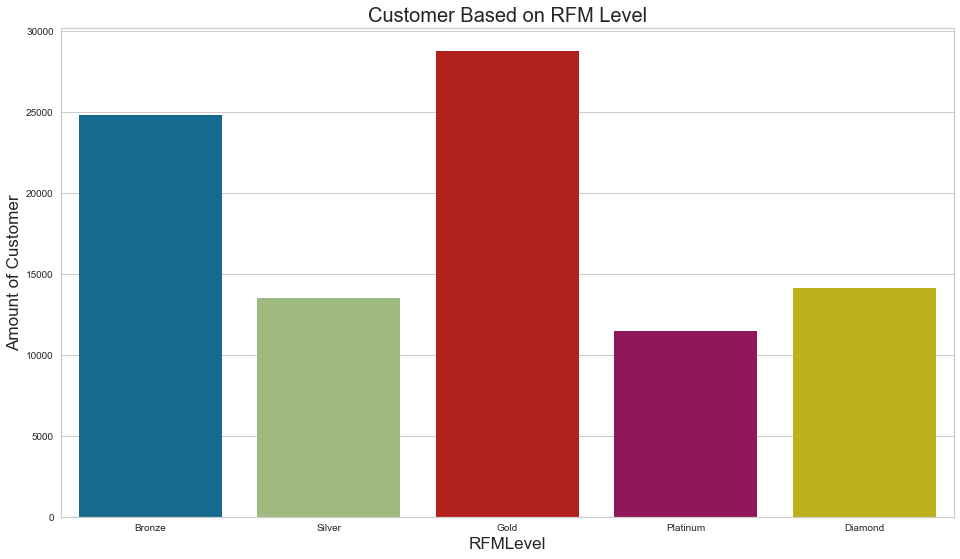

In [110]:
# ¿Cuántos clientes hay según su categoría?
rfm_cus_level = rfm_scaled.groupby('RFM_Level')['customer_unique_id'].nunique().reset_index()


fig=plt.figure(figsize=(16,9))
sns.barplot(y=rfm_cus_level['customer_unique_id'], x=rfm_cus_level['RFM_Level'])
plt.title('Customer Based on RFM Level',fontsize=20)
plt.xlabel('RFMLevel',fontsize=17)
plt.ylabel('Amount of Customer',fontsize=17)

Vemos que con este nuevo agrupamiento prevalecen los clientes de tipo gold. 
Por el analisis realizado no es la mejor clusterizacion la de 5 grupos 
Debemos elegir entre la de 3 o 4 clusters, justificar, establecer las conclusiones de cada grupo y la campaña de accion
a tomar desde el punto de vista del marketing 

Usar las conclusiones de mas arriba de guia pero borrarlas de ese lugar 